# Training a custom model


In [16]:
import torch
import torch.nn as nn
import timm
import json
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import tqdm
import datetime
import os
import os
import json
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

In [17]:
class KeypointDetector(nn.Module):
    def __init__(self, num_keypoints):
        super(KeypointDetector, self).__init__()

        # Using timm's resnet50 as the backbone
        self.backbone = timm.create_model('resnet50', pretrained=True, num_classes=0, global_pool='')

        # Decoder: Simple example with transposed convolutions
        # Adjust the number of layers or channels based on your needs
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, num_keypoints, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.decoder(x)
        return x

# Example usage
model = KeypointDetector(num_keypoints=10)  # Assuming you have 10 keypoints
input_tensor = torch.randn(2, 3, 288, 480)
output = model(input_tensor)
print(output.shape)  # Should be [2, 10, 224, 224] as each keypoint will have its own mask


torch.Size([2, 10, 288, 480])


In [18]:
class KeypointDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_list = os.listdir(os.path.join(root_dir, "images"))
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        # Loading the image using OpenCV
        img_name = self.image_list[idx]
        img_path = os.path.join(self.root_dir, "images", img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Loading the annotation (keypoints)
        ann_path = os.path.join(self.root_dir, "annotations", os.path.splitext(img_name)[0] + ".json")
        with open(ann_path, 'r') as f:
            annotation = json.load(f)
        
        keypoints = annotation['keypoints']
        mask = self.keypoints_to_mask(image.shape, (480, 288), keypoints)
        
        # Resizing the image using OpenCV
        image = cv2.resize(image, (480, 288))

        image = (torch.tensor(image.transpose(2,0,1)) / 255).float()
        mask =  (torch.tensor(mask) / 255).float()

        self.transform = T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

        if self.transform:
            # Depending on the transform library, you may need to change this
            image = self.transform(image)
            
        return image, mask
    
    def keypoints_to_mask(self, image_shape, img_size, keypoints):
        
        # create two masks for the two keypoints (head and tail)
        masks = [np.zeros(image_shape[:2]), np.zeros(image_shape[:2])]
        for k in keypoints:
            cv2.circle(masks[0], (int(k[0][0]), int(k[0][1])), 15, 1, -1)
            cv2.circle(masks[1], (int(k[1][0]), int(k[1][1])), 15, 1, -1)

        for i in range(len(masks)):
            # resize
            masks[i]  = cv2.resize(masks[i], img_size)
    
        return masks

def collate_fn(batch):
    """
    Collate function to format the batch in the desired manner.
    
    Parameters:
    - batch (list): List of tuples where each tuple contains an image tensor and its associated target.
    
    Returns:
    - tuple: Tuple containing a tensor of images and a list of targets.
    """
    # Separate images and targets in the batch
    images, targets = zip(*batch)
    
    # Stack images
    images = torch.stack(images)
    targets = torch.stack(targets)

    return images, targets

# if cuda is avaliable, use it
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

train_path = 'dataset/train'
test_path = 'dataset/test'


train_dataset = KeypointDataset(train_path)
test_dataset = KeypointDataset(test_path)

train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False, collate_fn=collate_fn)

# Get a batch of images and annotations from the train dataloader
images, targets = next(iter(test_dataloader))

print(images.shape)  # Should be [3, 288, 480]
print(targets.shape)  # Should be [2, 288, 480]

cuda
torch.Size([1, 3, 288, 480])
torch.Size([1, 2, 288, 480])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


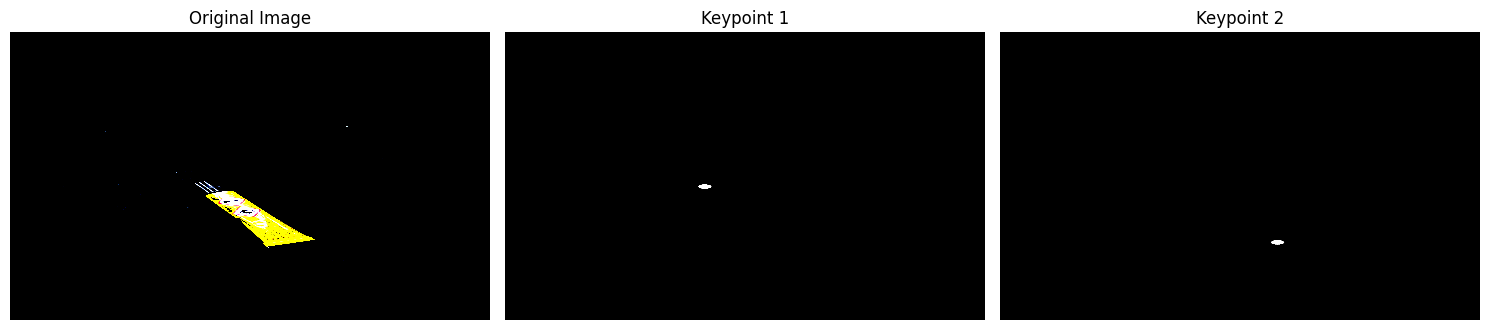

In [19]:
def visualize_image_and_masks(image, masks):
    """
    Visualize the input image and its corresponding keypoint masks side-by-side.

    Parameters:
    - image (torch.Tensor): Tensor representing the image. Shape: [3, height, width]
    - masks (torch.Tensor): Tensor representing the keypoint masks. Shape: [num_keypoints, height, width]
    """
    
    # Convert the image tensor to numpy array in the format [height, width, channels]
    img_np = image.permute(1, 2, 0).numpy()

    # Number of subplots (1 for original image + number of keypoints)
    num_keypoints = masks.shape[0]
    
    # Create a figure with subplots
    plt.figure(figsize=(15, 5))

    # Display the original image
    plt.subplot(1, num_keypoints + 1, 1)
    plt.imshow(img_np)
    plt.axis('off')
    plt.title('Original Image')

    # Display each keypoint mask
    for i in range(num_keypoints):

        plt.subplot(1, num_keypoints + 1, i + 2)
        plt.imshow(masks[i].numpy(), cmap='gray')  # Using gray colormap for masks
        plt.axis('off')
        plt.title(f'Keypoint {i+1}')

    plt.tight_layout()
    plt.show()

# Example Usage:
idx = 0  # Index of the image in the batch to visualize. Change as needed.
visualize_image_and_masks(images[idx], targets[idx])


In [20]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        # inputs = F.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [21]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, inputs, targets, smooth=1e-6):
        
        # First compute the BCE
        bce = self.bce(inputs, targets)
        
        # Now compute the Dice Loss
        inputs = torch.sigmoid(inputs)
        
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        
        return self.alpha * bce + self.beta * dice_loss


In [22]:
# Setup
num_epochs = 10
learning_rate = 5e-4
weight_decay = 5e-6

# Create a directory with the current timestamp
now = datetime.datetime.now()
timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
save_dir = os.path.join("saved_models", timestamp)
os.makedirs(save_dir, exist_ok=True)

model = KeypointDetector(num_keypoints=2)  # As we are dealing with 2 keypoints: head and tail.
model = model.to(device)

# criterion = nn.BCELoss()  # Using binary cross-entropy as we're predicting masks (sigmoid output)
# criterion = DiceLoss()  # Using binary cross-entropy as we're predicting masks (sigmoid output)
criterion = CombinedLoss(alpha=0.5, beta=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Training & Validation Loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, targets in tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}"):
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)

        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for images, targets in tqdm(test_dataloader, desc=f"Validation Epoch {epoch + 1}/{num_epochs}"):
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            valid_loss += loss.item()
    
    avg_valid_loss = valid_loss / len(test_dataloader)
    
    # Logging
    print(f"Epoch {epoch + 1}/{num_epochs} => "
          f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}")
    
    # Checkpointing (save model every epoch as an example)
    checkpoint_path = os.path.join(save_dir, f"epoch_{epoch + 1}.pth")

    # save model
    torch.save(model.state_dict(), checkpoint_path)


Validation Epoch 1/10: 100%|██████████| 23/23 [00:01<00:00, 11.59it/s]


Epoch 1/10 => Training Loss: 0.8622, Validation Loss: 0.8466


Validation Epoch 2/10: 100%|██████████| 23/23 [00:01<00:00, 11.83it/s]


Epoch 2/10 => Training Loss: 0.8466, Validation Loss: 0.8466


Validation Epoch 3/10: 100%|██████████| 23/23 [00:02<00:00, 11.49it/s]


Epoch 3/10 => Training Loss: 0.8466, Validation Loss: 0.8466


Validation Epoch 4/10: 100%|██████████| 23/23 [00:01<00:00, 11.67it/s]


Epoch 4/10 => Training Loss: 0.8466, Validation Loss: 0.8466


Validation Epoch 5/10: 100%|██████████| 23/23 [00:02<00:00, 11.47it/s]


Epoch 5/10 => Training Loss: 0.8466, Validation Loss: 0.8466


Validation Epoch 6/10: 100%|██████████| 23/23 [00:01<00:00, 11.57it/s]


Epoch 6/10 => Training Loss: 0.8466, Validation Loss: 0.8466


Validation Epoch 7/10: 100%|██████████| 23/23 [00:01<00:00, 11.59it/s]


Epoch 7/10 => Training Loss: 0.8466, Validation Loss: 0.8466


Validation Epoch 8/10: 100%|██████████| 23/23 [00:01<00:00, 11.72it/s]


Epoch 8/10 => Training Loss: 0.8466, Validation Loss: 0.8466


Validation Epoch 9/10: 100%|██████████| 23/23 [00:02<00:00, 11.49it/s]


Epoch 9/10 => Training Loss: 0.8466, Validation Loss: 0.8466


Validation Epoch 10/10: 100%|██████████| 23/23 [00:02<00:00, 11.37it/s]


Epoch 10/10 => Training Loss: 0.8466, Validation Loss: 0.8466


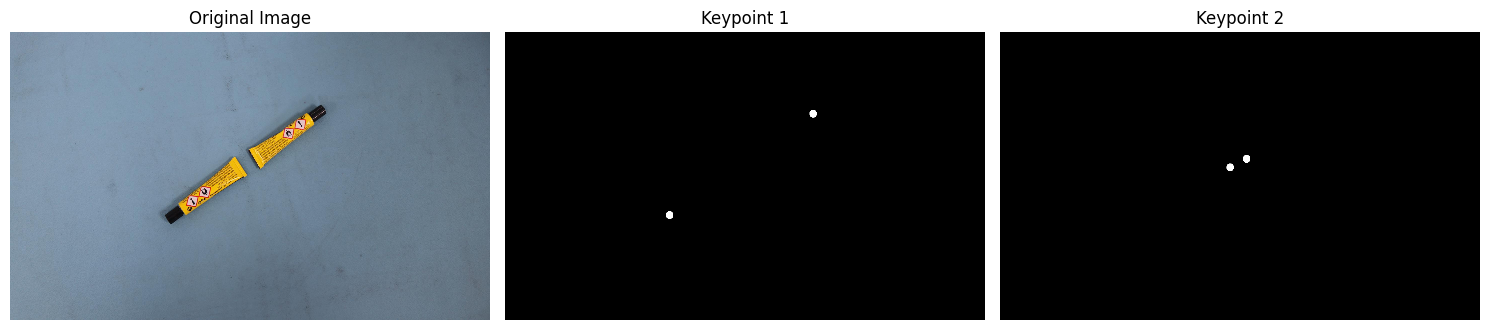

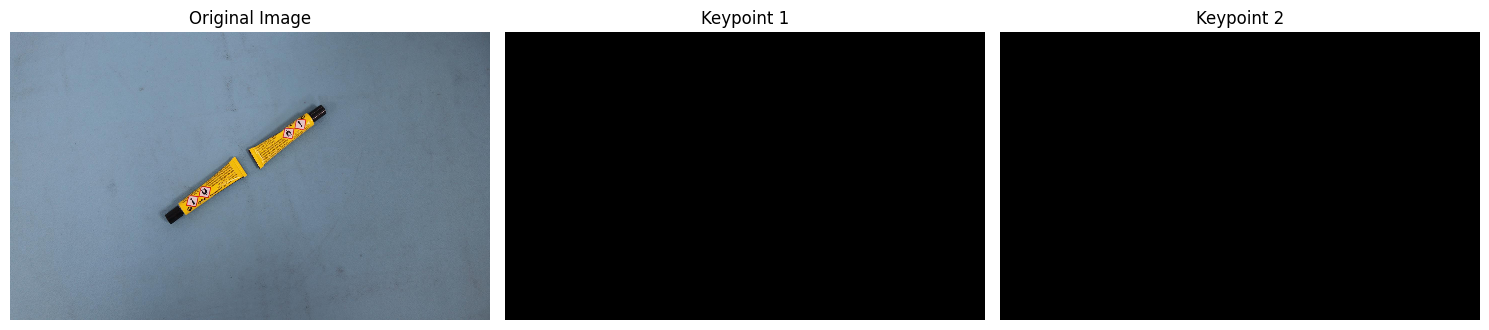

In [24]:
# Get the list of directories in saved_models
dirs = os.listdir("saved_models")

# Sort the directories by creation time
dirs = sorted(dirs, key=lambda x: os.path.getctime(os.path.join("saved_models", x)))

# Get the path of the most recent directory
latest_dir = os.path.join("saved_models", dirs[-1])

# Get the path of the last saved model inside the most recent directory
model_path = os.path.join(latest_dir,sorted(os.listdir(latest_dir))[-1])

# Load the last saved checkpoint
model = KeypointDetector(num_keypoints=2).to(device)
model.load_state_dict(torch.load(model_path))
model.eval().to(device)

# %%
# Get an image from the test dataset
image, target = test_dataset[2]  # Change index as needed
image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# invert std and mean
image[0][0] = image[0][0] * 0.229 + 0.485
image[0][1] = image[0][1] * 0.224 + 0.456
image[0][2] = image[0][2] * 0.225 + 0.406


# Predict the mask using the loaded model
with torch.no_grad():
    predicted_mask = model(image)

    # Binarizar la salida usando un umbral de 0.5
    threshold = 0.5
    predicted_mask[predicted_mask >= threshold] = 1
    predicted_mask[predicted_mask < threshold] = 0

    # convert to int
    predicted_mask = predicted_mask.type(torch.uint8)

# Visualize the mask and the image
visualize_image_and_masks(image.cpu().squeeze(0),target.cpu().squeeze(0))
visualize_image_and_masks(image.cpu().squeeze(0),predicted_mask.cpu().squeeze(0))
